#Data Processing
This notebook assumes the data is in place. You can get data by running data_collection.ipynb.

In [1]:
# Imports needed for this ipython file

from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import numpy as np
import operator
import math

%matplotlib inline

In [2]:
# Unpickle everything
iit_followers = pickle.load(open('processed_data/iit_followers'))
friends_of_iit_followers = pickle.load(open('raw_data/friends_of_iit_followers'))
friend_ids_of_iit_followers   = pickle.load(open('raw_data/friend_ids_of_iit_followers'))

In [3]:
iit_alumni_followers = pickle.load(open('raw_data/iitalumniassn'))
iit_career_followers = pickle.load(open('raw_data/IITCareers'))
iit_univ_followers   = pickle.load(open('raw_data/illinoistech'))

In [6]:
def get_all_follower_objects(*args):
    """ Returns union of all follower objects of a particular university
    
    Args: Variables containing followers from different accounts in dictionary format.
    
    Returns : A dictionary of { follower_screen_name : follower_object } pairs.
    """
    univ_followers = {}
    for followers in args:
        for key, value in followers.items():
            univ_followers[key] = value
    return univ_followers

In [5]:
iit_follower_objects = get_all_follower_objects(iit_alumni_followers,iit_career_followers,iit_univ_followers)

In [7]:
processed_iit_follower = {}
for follower, follower_object in iit_follower_objects.items():
    processed_iit_follower[follower_object["id"]] = follower

In [8]:
iit_follower_name_to_id = {}
for follower, follower_object in iit_follower_objects.items():
    iit_follower_name_to_id[follower] = follower_object["id"]

In [ ]:
print len(friend_ids_of_iit_followers.keys())
print friend_ids_of_iit_followers

In [10]:
friend_ids_of_iit_followers_corrected = {}
for key,value in friend_ids_of_iit_followers.items():
    friend_ids_of_iit_followers_corrected[iit_follower_name_to_id[key]] = value

fileObject = open("processed_data/friend_ids_of_iit_followers",'wb')
pickle.dump(friend_ids_of_iit_followers_corrected,fileObject)
fileObject.close()

In [2]:
friend_ids_of_iit_followers_corrected = pickle.load(open('processed_data/friend_ids_of_iit_followers'))
processed_iit_follower = pickle.load(open('processed_data/iit_follower_id_to_name_mapping'))
friend_ids_of_iit_followers = pickle.load(open('raw_data/friend_ids_of_iit_followers'))

In [12]:
error3_count = []
follower_count = []
other_error_count = []
for follower, friends in friend_ids_of_iit_followers_corrected.items():
    if not isinstance(friends,(int,long)):
        if len(friends) > 1000:
            error3_count.append(len(friends))
        follower_count.append(len(friends))
    else:
        other_error_count.append(follower)
print len(friend_ids_of_iit_followers_corrected.keys())
print len(error3_count)
print len(other_error_count)
print len(follower_count)

6565
1116
661
5904


In [13]:
print np.mean(error3_count)
print np.median(error3_count)

1838.03673835
1776.5


In [14]:
print len(processed_iit_follower.keys())
print len(friend_ids_of_iit_followers_corrected.keys())

6565
6565


In [15]:
# Pickling iit_follower_objects for future calculations.
fileObject = open("raw_data/iit_follower_objects",'wb')
pickle.dump(iit_follower_objects,fileObject)
fileObject.close()

In [16]:
# Pickling iit_follower_ids for graph calculations.
fileObject = open("processed_data/iit_follower_id_to_name_mapping",'wb')
pickle.dump(processed_iit_follower,fileObject)
fileObject.close()

In [3]:
G = nx.DiGraph()

In [4]:
for iit_follower_id, iit_follower_name in processed_iit_follower.items():
    if not isinstance(friend_ids_of_iit_followers_corrected[iit_follower_id],(int,long)):
        G.add_node(iit_follower_id, name = iit_follower_name)

In [5]:
for follower_name, friend_ids in friend_ids_of_iit_followers_corrected.items():
    if not isinstance(friend_ids,(int,long)):
        for friend_id in friend_ids:
            if friend_id in G:
                G.add_edge(follower_name,friend_id)

In [6]:
print len(G.nodes())
print len(G.edges())

5904
62891


In [4]:
def get_top_20_ranked_nodes(graph,n=20):
    """ Returns 20 nodes having highest PageRank values
    Args: A DiGraph object is passed as input
    Returns : A list of n nodes having highest PageRank values
    """
    pr = nx.pagerank(graph, alpha=0.9)
    sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
    return [node[0] for node in sorted_pr[-n:]]

def get_color(node, pr):
    """ Returns color values based on PageRank value of node
        if node is in top n rank, then it is colored blue; otherwise white
    """
    if node in pr:
        return 'r'
    else:
        return 'w'

def get_label(node, data, pr):
    """ Returns data label of node based on PageRank value of node
        if node is in top 20, then data value is returned; otherwise empty string
    """
    if node in pr:
        return data
    else:
        return ''

def get_edge_list(graph, nodelist):
    """ Returns a list of edges, of nodes in nodelist
    """
    edges = []
    for n in nodelist:
        for edge in nx.edges(graph,n):
            if edge[0] in nodelist:
                if edge[0] in nodelist:
                    edges.append(edge)
    return edges

def get_node_list(graph, edgelist):
    """ Returns a list of all nodes that are in edgelist
    """
    node_list = set()
    for edge in edgelist:
        node_list.add(edge[0])
        node_list.add(edge[1])
    return list(node_list)

def draw_network(graph,title):
    
    pr = get_top_20_ranked_nodes(graph)
    edgelist = get_edge_list(graph, pr)
    nodelist = get_node_list(graph,edgelist)
    colors = [get_color(node,pr) for node in nodelist]
    data = nx.get_node_attributes(graph,'name') 
    labels = {node: get_label(node,data[node],pr) for node in nodelist}
    
    shells = []
    second_layer = []
    
    for node in nodelist:
        if node not in pr:
            second_layer.append(node)
    shells.append(second_layer)
    shells.append(pr)
    
    fig = plt.figure(figsize=(10,10))
    nx.draw_networkx(graph, 
                     #pos=nx.spring_layout(graph,k=1./math.sqrt(graph.number_of_nodes()+1000),scale=10.0),
                     #pos=nx.circular_layout(graph),
                     pos=nx.shell_layout(graph,shells),
                     node_color=colors,
                     labels=labels,
                     nodelist = nodelist,
                     edgelist = edgelist,
                     alpha=.5,
                     width=.1,
                     arrows = False,
                     node_size=100)
    plt.axis("off")
    plt.title(title)
    plt.savefig("Output "+title+".pdf")
    plt.show()

#draw_network(G)

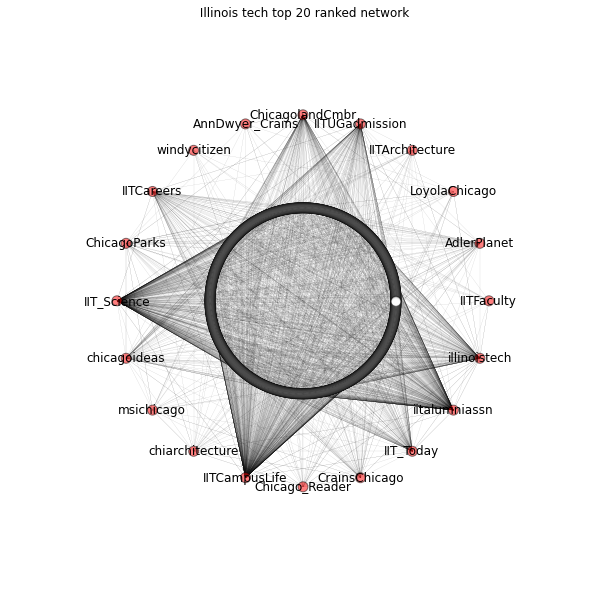

In [27]:
draw_network(G," Illinois tech top 20 ranked network")

In [15]:
def plot_degree_distribution(G,title,n):
    """ Plotting 3 bar graphs which displays the following :
        graph 1 : displays the degree distribution of first 1/3rd
                        of entire graph's nodes sorted by degree.
        graph 2 : displays the first 20 degree distribution of nodes
                        (i.e.) having degrees 1 - 20
        graph 3 : displays the last 20 degree distribution of nodes
                        (i.e.) nodes having 20 largest degree values in graph
    """
    degrees = nx.degree(G)
    degree_counts = Counter(degrees.values())
    p_k = [(degree, 1. * count / len(G.nodes()))
           for degree, count in degree_counts.iteritems()]
    p_k = sorted(p_k)
    ks = [x[0] for x in p_k]  # Get the first element of each tuple (the degree)
    x_pos = range(len(ks))
    # Plot the bar chart.
    
    #Main graph till size
    plt.figure(figsize=(20,20))
    plt.subplot(311)
    x_pos_1 = x_pos[:len(x_pos)/n]
    ks_1 = ks[:len(ks)/n]
    p_k_1 = p_k[:len(p_k)/n]
    plt.xticks(x_pos_1, ks_1)
    plt.bar(x_pos_1, [x[1] for x in p_k_1], align='center', alpha=0.4, width = 1)
    # Label the x ticks.
    # Label axes and title.
    plt.xlabel('$k$')
    plt.ylabel('$P(k)$')
    plt.title(title+" (first 1/"+str(n)+" part of graph)")
    
    #Subplots
    #First 20
    plt.subplot(312)
    x_pos_2 = x_pos[:20]
    ks_2 = ks[:20]
    p_k_2 = p_k[:20] 
    plt.xticks(x_pos_2, ks_2)
    plt.bar(x_pos_2, [x[1] for x in p_k_2], align='center', alpha=0.4, width = 0.5)
    plt.xlabel('$k$')
    plt.ylabel('$P(k)$')
    plt.title("Degree Distribution of first 20 degrees")
    
    # Last 10
    plt.subplot(313)
    x_pos_3 = x_pos[-20:]
    ks_3 = ks[-20:]
    p_k_3 = p_k[-20:] 
    plt.xticks(x_pos_3, ks_3)
    plt.bar(x_pos_3, [x[1] for x in p_k_3], align='center', alpha=0.4, width = 0.5)
    
    plt.xlabel('$k$')
    plt.ylabel('$P(k)$')
    plt.title("Degree Distribution of last 20 degrees")
    
    plt.savefig("Output "+title+".pdf")
    plt.show()

#plot_degree_distribution(G)

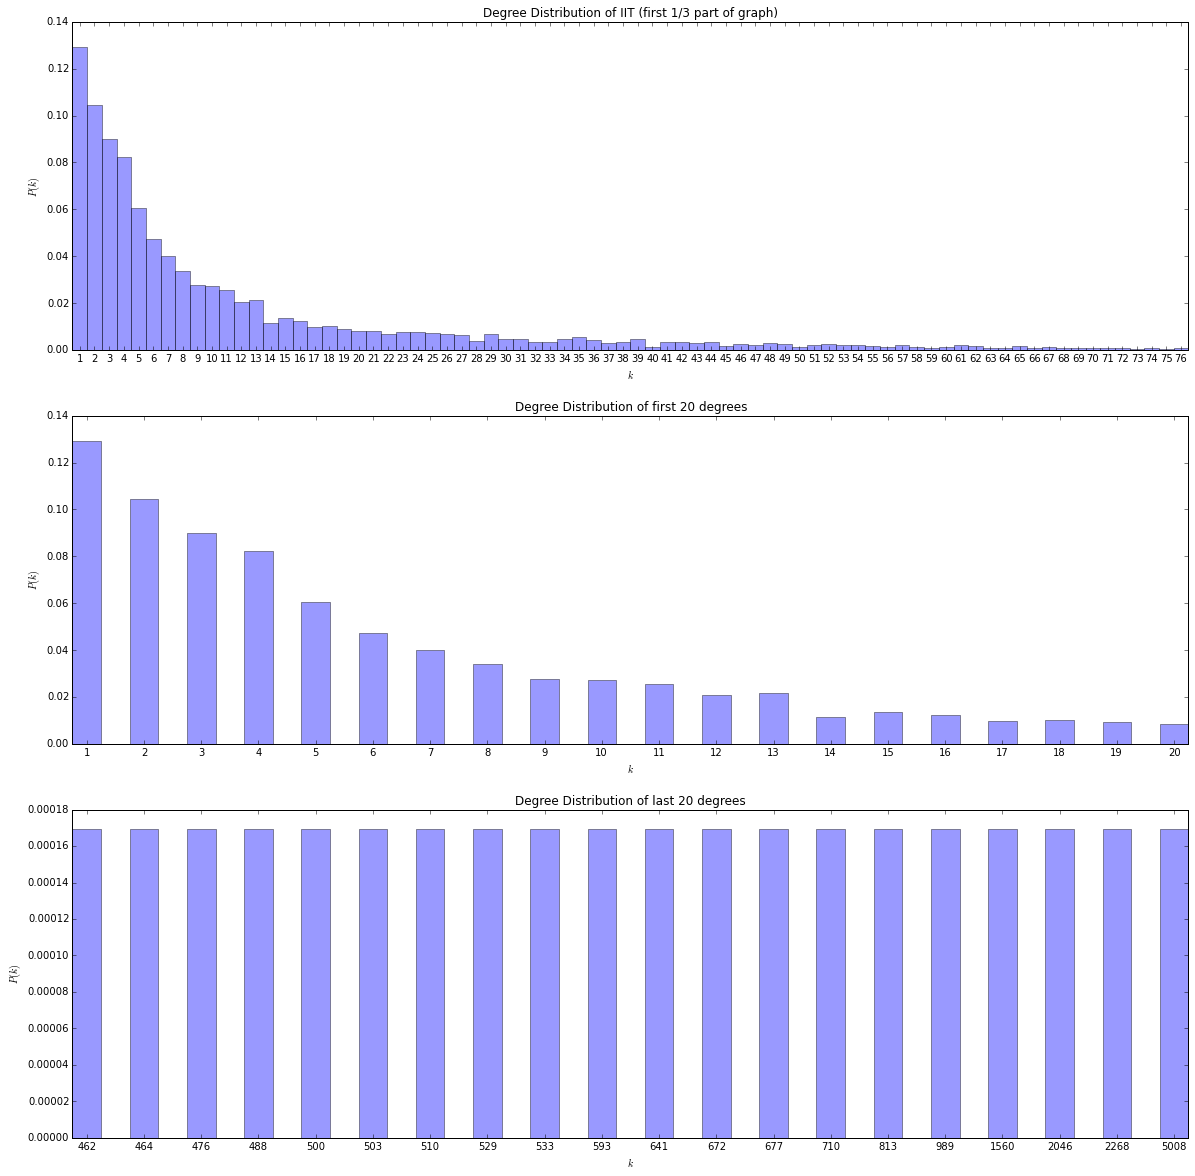

In [16]:
plot_degree_distribution(G,title = "Degree Distribution of IIT", n =3)

In [6]:
def plot_clustering_coefficient(G,title):
    """
    Plotting histogram of clustering coefficient values of a graph
    """
    plt.hist(nx.clustering(G.to_undirected()).values())
    plt.xlabel(title)
    plt.ylabel('count')
    plt.savefig("Output "+title+".pdf")
    plt.show()

#plot_clustering_coefficient(G.copy())

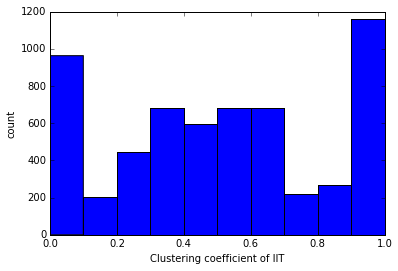

In [33]:
plot_clustering_coefficient(G.copy(),title = "Clustering coefficient of IIT")

In [14]:
def remove_zero_degree_nodes(G,verbose = False):
    """ Find and remove nodes having zero degrees
    Args : A graph G is passed as input
           A boolean variable verbose, to display which nodes were removed.
    Returns : A graph G with zero degree nodes removed
    """
    zero_degree_nodes = []
    for n in nx.nodes(G):
        if not nx.edges(G,n): # Checking if number of edges for n is 0
            #print n , processed_iit_follower[n], friend_ids_of_iit_followers_corrected[n]
            zero_degree_nodes.append(n)
    
    if verbose:
        if not zero_degree_nodes:
            print "No nodes removed"
        else:
            print zero_degree_nodes
    
    if zero_degree_nodes:
        for node in zero_degree_nodes:
            G.remove_node(node)
            
    return G

#G = remove_zero_degree_nodes(G,verbose = True)
G2 = remove_zero_degree_nodes(G2,verbose = True)

[3242765770L, 3025057339L, 4128424695L, 3242782241L, 1263222630, 955860108, 2768629288L, 258200262, 4041729081L]


#Processing data for North Western University

In [3]:
nu_followers = pickle.load(open('processed_data/nu_followers'))

In [7]:
nu_alumni_followers = pickle.load(open('raw_data/nualumni'))
nu_career_followers = pickle.load(open('raw_data/NUCareerAdvance'))
nu_univ_followers   = pickle.load(open('raw_data/NorthwesternU'))

In [9]:
nu_follower_objects = get_all_follower_objects(nu_univ_followers,nu_alumni_followers,nu_career_followers)

# Pickling nu_follower_objects for future calculations.
fileObject = open("raw_data/nu_follower_objects",'wb')
pickle.dump(nu_follower_objects,fileObject)
fileObject.close()

In [5]:
# Reading follower objects from pickle
nu_follower_objects = pickle.load(open('raw_data/nu_follower_objects'))

In [6]:
processed_nu_follower = {}
for follower, follower_object in nu_follower_objects.items():
    processed_nu_follower[follower_object["id"]] = follower

In [7]:
# Pickling nu_follower_ids for graph calculations.
fileObject = open("processed_data/nu_follower_id_to_name_mapping",'wb')
pickle.dump(processed_nu_follower,fileObject)
fileObject.close()

In [18]:
friend_ids_of_nu_followers = pickle.load(open('raw_data/friend_ids_of_nu_followers'))

In [22]:
friend_ids_of_nu_followers_corrected = {}
for key,value in friend_ids_of_nu_followers.items():
    follower_object = nu_follower_objects[key]
    friend_ids_of_nu_followers_corrected[follower_object["id"]] = value
    
fileObject = open("processed_data/friend_ids_of_nu_followers",'wb')
pickle.dump(friend_ids_of_nu_followers_corrected,fileObject)
fileObject.close()

In [12]:
# Data required for graph
friend_ids_of_nu_followers_corrected = pickle.load(open('processed_data/friend_ids_of_nu_followers'))
processed_nu_follower = pickle.load(open("processed_data/nu_follower_id_to_name_mapping"))

In [13]:
# Create NU graph
G2 = nx.DiGraph()

# Adding nodes
for nu_follower_id, nu_follower_name in processed_nu_follower.items():
    if not isinstance(friend_ids_of_nu_followers_corrected[nu_follower_id],(int,long)):
        G2.add_node(nu_follower_id, name = nu_follower_name)
        
#Adding edges
for follower_name, friend_ids in friend_ids_of_nu_followers_corrected.items():
    if not isinstance(friend_ids,(int,long)):
        for friend_id in friend_ids:
            if friend_id in G2:
                G2.add_edge(follower_name,friend_id)

In [15]:
print len(G2.nodes())
print len(G2.edges())

31053
774700


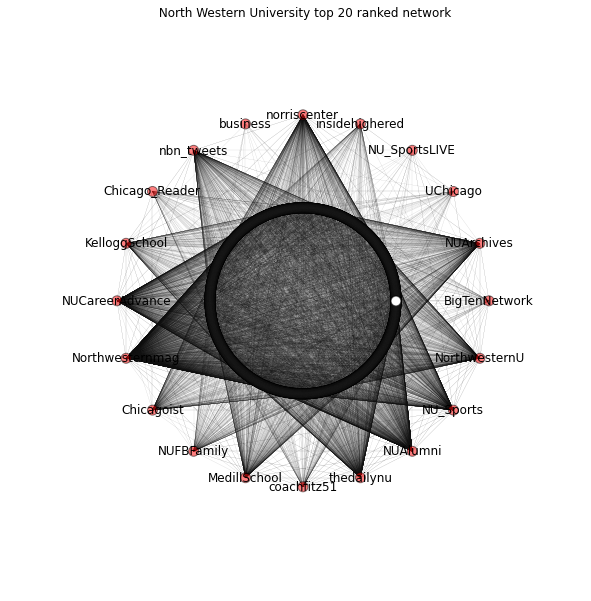

In [9]:
draw_network(G2," North Western University top 20 ranked network")

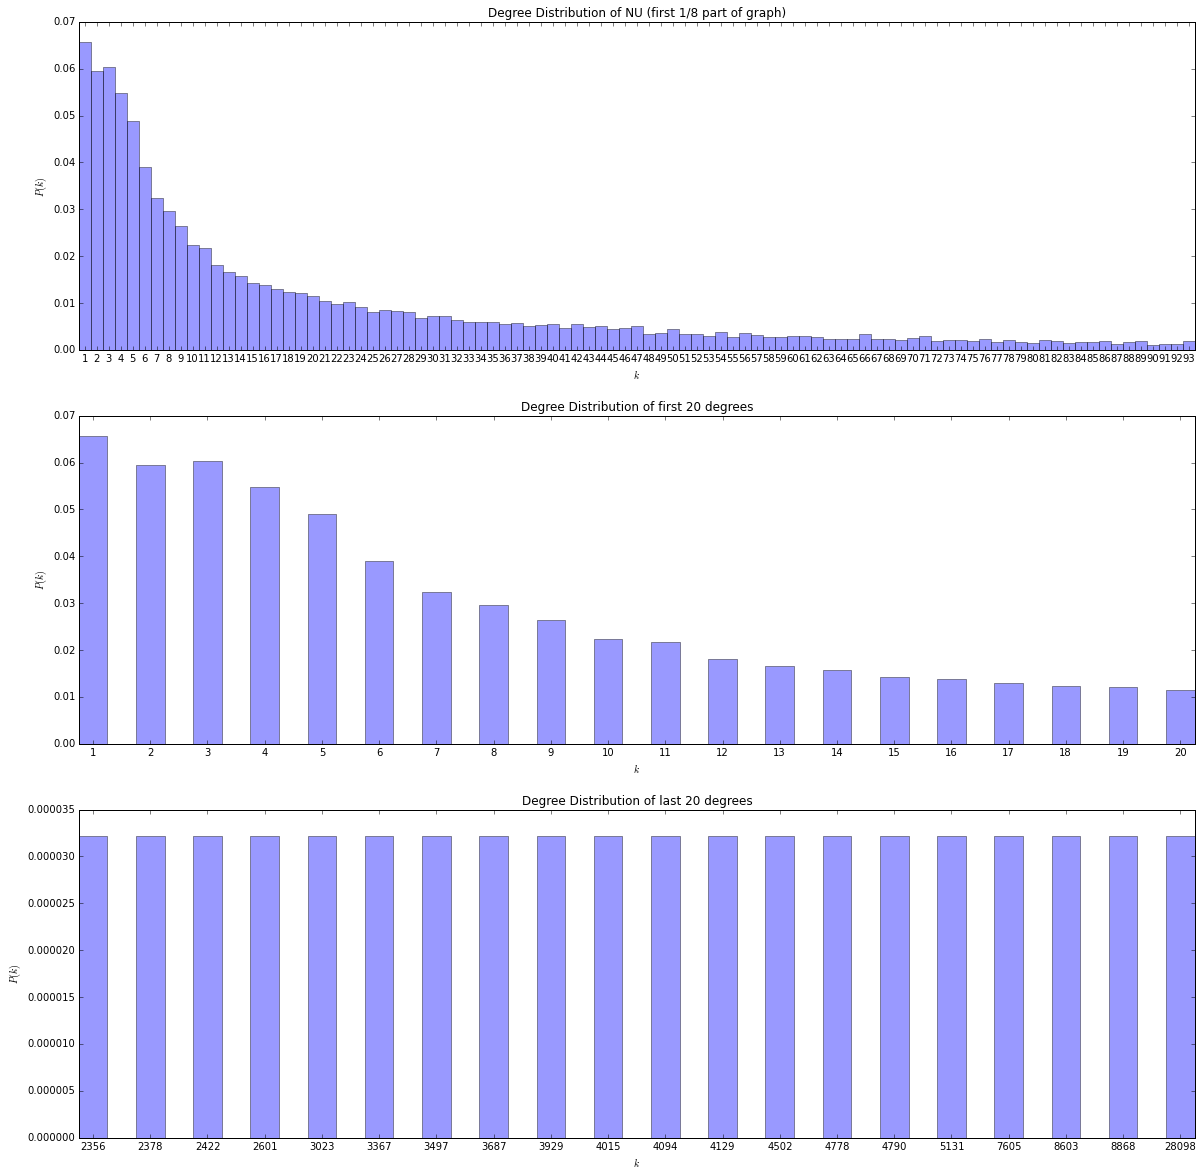

In [21]:
plot_degree_distribution(G2,title = "Degree Distribution of NU",n=8)

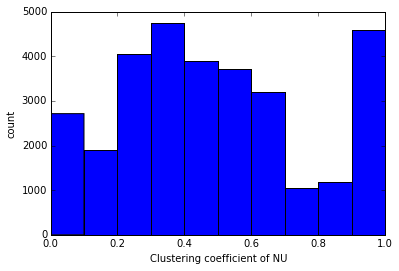

In [14]:
plot_clustering_coefficient(G2.copy(),title = "Clustering coefficient of NU")